In [84]:
from util_func import *
import cv2 as cv
import sys
assert sys.version_info >= (3, 7)
import numpy as np
import matplotlib.pyplot as plt

In [72]:
!pip install requests

You are using pip version 9.0.1, however version 23.2.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# Learning outcomes
1. K-means clustering
2. Anisotropic segmentation
3. Watershed segmentation

## K-means Clustering

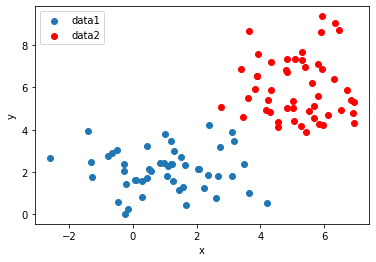

In [14]:
# get same pattern on random result
np.random.seed(0)
## generate / sample data points from bivariate Gaussian probability distribution
# parameters are mean and covariance (2x2 matrix)
mean1 = (1, 2)
cov1 = np.array([[2, 0], [0,1]])
dat1 = np.random.multivariate_normal(mean1, cov1, size=50)

mean2 = (5, 6)
cov2 = np.array([[1, 0],[0, 2]])
dat2 = np.random.multivariate_normal(mean2, cov2, size=50)

# combine into dataset
data = np.concatenate((dat1, dat2), axis=0)
Z = np.float32(data)

plt.scatter(dat1[:, 0], dat1[:, 1], label="data1")
plt.scatter(dat2[:, 0], dat2[:, 1], c="r", label="data2")
plt.legend()
plt.xlabel("x"), plt.ylabel("y")
plt.show()

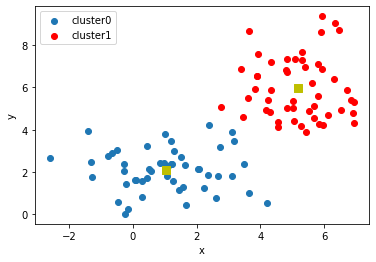

In [16]:
# apply k-means
criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, label, center = cv.kmeans(Z, 2, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
# ret is WCOS

# subset the cluster
A = Z[label.flatten() == 0]
B = Z[label.flatten() == 1]

plt.scatter(A[:, 0], A[:, 1], label="cluster0")
plt.scatter(B[:, 0], B[:, 1], c="r", label="cluster1")
plt.scatter(center[:, 0], center[:, 1], c="y", s=80, marker="s")
plt.legend()
plt.xlabel("x"), plt.ylabel("y")
plt.show()

## Applying k-means clustering on images
 - Needs reshaping

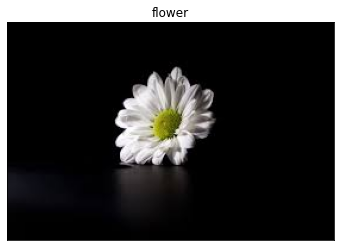

In [44]:
img = cv.imread("images/flower.jfif")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt_img(img_rgb, "flower")

In [7]:
def kmc(img, K, max_iter=10, eps=1.0, attempts=10, flag=cv.KMEANS_PP_CENTERS):
    """Args:
    img:  3-channel image array
    K:  number of clusters
    By default, max_iter = 10, eps = 1.0, attempts = 10, k-means++"""
    img = img.reshape((-1, 3))
    img = np.float32(img)
    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, max_iter, eps)
    return cv.kmeans(img, K, None, criteria, attempts, flag)

ret, label, center = kmc(img_rgb, 3)
    

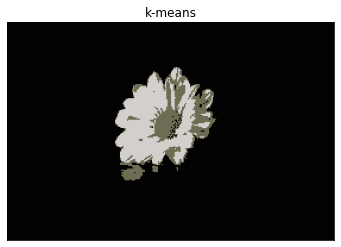

In [46]:
# Output Visualization
# cast to uint8
center = np.uint8(center)
res = center[label.flatten()]
quant = res.reshape(img_rgb.shape)

plt_img(quant, "k-means")


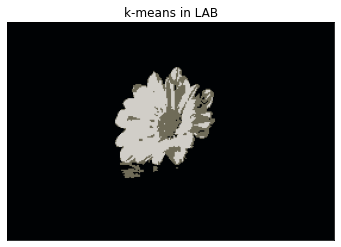

In [48]:
# LAB color space has the property of perceptual uniformity
img = cv.imread("images/flower.jfif")
img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)
ret, label, center = kmc(img_lab, 3)
center = np.uint8(center)
res = center[label.flatten()]
quant = res.reshape(img_lab.shape)

quant_rgb = cv.cvtColor(quant, cv.COLOR_Lab2RGB)
plt_img(quant_rgb, "k-means in LAB")

In [49]:
np.unique(res, axis=0, return_counts=True)

(array([[  1, 128, 127],
        [115, 126, 139],
        [211, 128, 131]], dtype=uint8),
 array([45468,  1772,  3085], dtype=int64))

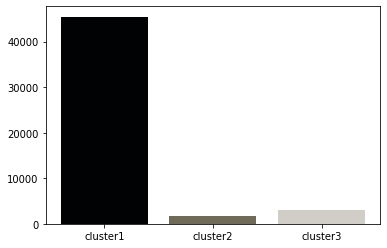

In [53]:
# make a bar pot for all the cluster
centroids, counts = np.unique(res, axis=0, return_counts=True)
# change Lab to RGB
res_rgb = centroids.reshape((3, 1, 3))
res_rgb = cv.cvtColor(res_rgb, cv.COLOR_Lab2RGB)
res_rgb = res_rgb.reshape((3, 3))

# retrieve the counts
xlabel_name = ['cluster'+str(i) for i in range(1, 4)]
plt.bar(xlabel_name, counts, color=list(res_rgb/255))
plt.show()

In [54]:
def calcGST(inputIMG, w, method_edge="scharr"):
    img = np.float32(inputIMG)
    
    # Gradient structure tensor components
    if method_edge=="scharr":
        imgDiffX = cv.Scharr(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Scharr(img, cv.CV_32F, 0, 1)
    elif method_edge=="sobel":
        imgDiffX = cv.Sobel(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Sobel(img, cv.CV_32F, 0, 1)
    else:
        raise Exception("No edge detection method available")
    imgDiffXY = cv.multiply(imgDiffX, imgDiffY)
    imgDiffXX = cv.multiply(imgDiffX, imgDiffX)
    imgDiffYY = cv.multiply(imgDiffY, imgDiffY)
    
    J11 = cv.boxFilter(imgDiffXX, cv.CV_32F, (w, w))
    J22 = cv.boxFilter(imgDiffYY, cv.CV_32F, (w, w))
    J12 = cv.boxFilter(imgDiffXY, cv.CV_32F, (w, w))
    
    # eigenvalue
    tmp1 = J11+J22
    tmp2 = J11-J22
    tmp2 = cv.multiply(tmp2, tmp2)
    tmp3 = cv.multiply(J12, J12)
    tmp4 = np.sqrt(tmp2 + 4.0*tmp3)
    
    lambda1 = 0.5*(tmp1+tmp4)
    lambda2 = 0.5*(tmp1 - tmp4)
    
    # coherency
    imgCoherencyOut = cv.divide(lambda1-lambda2, lambda1+lambda2)
    
    # orientation calculation
    imgOrientationOut = cv.phase(J22-J11, 2.0*J12, angleInDegrees = True)
    imgOrientationOut = 0.5*imgOrientationOut
    
    return imgCoherencyOut, imgOrientationOut 

The issue of applying Gaussian filter instead of `cv.boxFilter()` line 17 to line 19 is numerical stability (division by zero). The way to remedy this issue is by adding the denominator by a small constant (line 35).

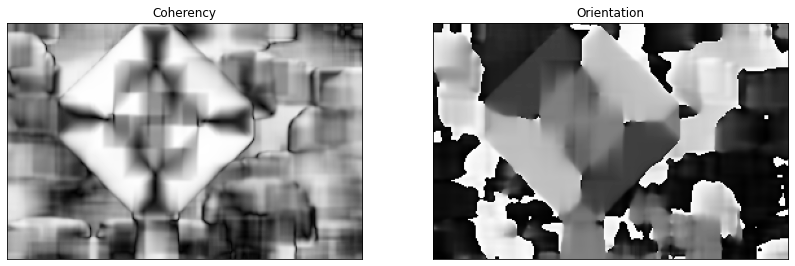

In [60]:
# display and coherency and orientation map
img = cv.imread("images/traffic_sign.jfif")
blur = cv.GaussianBlur(img, (5,5), 0)
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

W = 25
imgCoherency, imgOrientation = calcGST(gray, W)

# normalize
imgCoherency_norm = cv.normalize(imgCoherency, None, alpha=0, beta=1,
                                norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
imgOrientation_norm = cv.normalize(imgOrientation, None, alpha=0, beta=1,
                                norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

plt.figure(figsize=(14,12))
plt.subplot(121), plt_img(imgCoherency_norm, "Coherency")
plt.subplot(122), plt_img(imgOrientation_norm, "Orientation")
plt.show()

In [72]:
# trackbar function
def nothing(x):
    pass

wn = "anisotropic segmentation"
cv.namedWindow(wn, cv.WINDOW_NORMAL + cv.WINDOW_FREERATIO)
cv.createTrackbar("Coherency Threshold 1", wn, 50, 100, nothing)
cv.createTrackbar("Coherency Threshold 2", wn, 70, 100, nothing)
cv.createTrackbar("Orientation Threshold 1", wn, 50, 180, nothing)
cv.createTrackbar("Orientation Threshold 2", wn, 100, 180, nothing)

img = cv.imread("images/road.jpg")
blur = cv.GaussianBlur(img, (5,5), 0)
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

W = 25
imgCoherency, imgOrientation = calcGST(gray, W)

while True:
    # get trackbar position
    th_C_1 = cv.getTrackbarPos("Coherency Threshold 1", wn) * 0.01
    th_C_2 = cv.getTrackbarPos("Coherency Threshold 2", wn) * 0.01   
    th_Or_1 = cv.getTrackbarPos("Orientation Threshold 1", wn)
    th_Or_2 = cv.getTrackbarPos("Orientation Threshold 2", wn) 
    
    # thresholding
    imgBin_C_1 = cv.threshold(imgCoherency, th_C_1, 255, cv.THRESH_BINARY)[1]
    imgBin_C_2 = cv.threshold(imgCoherency, th_C_2, 255, cv.THRESH_BINARY_INV)[1]
    imgBin_Or_1 = cv.threshold(imgOrientation, th_Or_1, 255, cv.THRESH_BINARY)[1]
    imgBin_Or_2 = cv.threshold(imgOrientation, th_Or_2, 255, cv.THRESH_BINARY_INV)[1]   
    
    imgBin_C = cv.bitwise_and(imgBin_C_1, imgBin_C_2)
    imgBin_Or = cv.bitwise_and(imgBin_Or_1, imgBin_Or_2)
    
    imgBin = cv.bitwise_and(imgBin_C, imgBin_Or)
    
    mask = imgBin != 0
    res = img*(mask[:, :, None].astype(np.uint8))
    cv.imshow(wn, res)
    cv.imshow("segmentation", imgBin)
    k = cv.waitKey(1) & 0xFF
    if k==27:
        break
        
cv.destroyAllWindows()

## Watershed segmentation
 - Topographic surface : edge map
 - Marker : morphological gradient + threshold

In [140]:
from skimage.segmentation import watershed
from scipy import ndimage as ndi

In [141]:
# load image
img = cv.imread("images/traffic_sign.jfif")
blur = cv.GaussianBlur(img, (5,5), 0)
blur = cv.pyrMeanShiftFiltering(blur, 15, 20, maxLevel=2)

show_img("blur", blur)

In [142]:
# grayscale
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

# morphological gradient
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11,11))
loc_grad = cv.morphologyEx(gray, cv.MORPH_GRADIENT, kernel, iterations=2)

show_img("img", loc_grad)

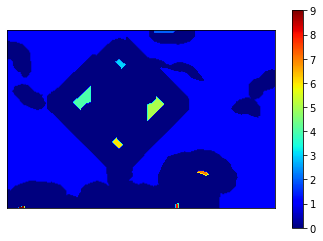

In [143]:
th = loc_grad < 80
# connected component labeling
s = np.ones((3, 3), dtype=int)
marker = ndi.label(th, structure=s)[0]

plt.imshow(marker, cmap=plt.cm.jet)
plt.colorbar()
plt.xticks([]), plt.yticks([])
plt.show()

In [144]:
edge = cv.Canny(gray, 250, 500)
labels = watershed(edge, marker)

In [145]:
np.unique(labels, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([40736,   279,  1234,  2325,  2295,  1270,  1066,   736,   384],
       dtype=int64))

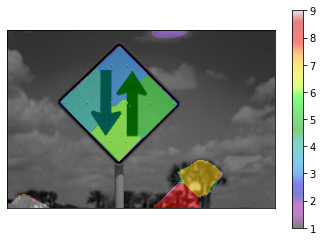

In [146]:
gray_ori = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(gray_ori, cmap="gray")
plt.imshow(labels, cmap=plt.cm.nipy_spectral, alpha=0.5)
plt.colorbar()
plt.xticks([]), plt.yticks([])
plt.show()

In [147]:
# create mask / binary image and set background to zero.
# assumption: background is always the majority

mask = 255 * np.ones(labels.shape, dtype=np.uint8)

label_vec, counts = np.unique(labels, return_counts=True)
label_bg = label_vec[np.argmax(counts)]

mask[labels==label_bg] = 0

# contours
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# grab the largest contour
contour = sorted(contours, key=cv.contourArea, reverse=True)[0]

img_copy = img.copy()
cv.drawContours(img_copy, [contour], -1, (0, 255, 0), 2)

show_img("contours", img_copy)

In [148]:
# bounding box
img_copy = img.copy()
x, y, w, h = cv.boundingRect(contour)
cv.rectangle(img_copy, (x,y) , (x+w, y+h), (0, 255, 0), 2)

show_img("bounding box", img_copy)

## Exercise

In [198]:
img = cv.imread("images/traffic_sign1.jpg")
(h, w) = img.shape[:2]
blur = cv.GaussianBlur(img, (5, 5), 0)

In [199]:
# Convert to Lab
img_lab = cv.cvtColor(blur, cv.COLOR_BGR2Lab)

img_lab = img_lab.reshape((h*w, 3))
img_lab = np.float32(img_lab)
# criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv.KMEANS_PP_CENTERS

compactness, labels, centers = cv.kmeans(img_lab, 10, None, criteria, 10, flags)

quant = centers.astype(np.uint8)[labels]
quant = quant.reshape((h, w, 3))

bgr = cv.cvtColor(quant, cv.COLOR_Lab2BGR)

show_img("kmeans quantization", bgr)

In [200]:
img_lab[..., 0].min()

6.0

In [201]:
gray = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)

th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

show_img("threshold", th)

In [202]:
from skimage.feature import peak_local_max

In [203]:
kernel = np.ones((3, 3), dtype=np.uint8)
th = cv.morphologyEx(th, cv.MORPH_OPEN, kernel, iterations=3)

dist_transform = cv.distanceTransform(th, cv.DIST_L2, 3)

coords = peak_local_max(dist_transform, footprint=np.ones((100, 100)), labels=th)

mask = np.zeros(dist_transform.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-dist_transform, markers, mask=th)

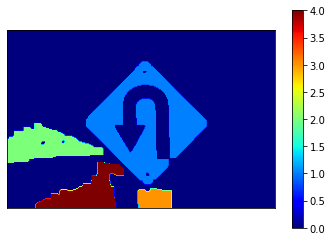

In [204]:
plt.imshow(labels, cmap=plt.cm.jet)
plt.colorbar(), plt.xticks([]), plt.yticks([])
plt.show()

In [205]:
edge = cv.Canny(gray, 250, 500)
labels = watershed(edge, marker)

In [206]:
np.unique(labels, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([40985,   562,  1824,  1767,   616,  1944,  2028,    64,   535],
       dtype=int64))

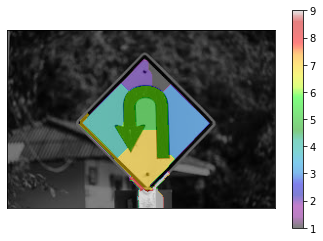

In [207]:
gray_ori = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(gray_ori, cmap="gray")
plt.imshow(labels, cmap=plt.cm.nipy_spectral, alpha=0.5)
plt.colorbar()
plt.xticks([]), plt.yticks([])
plt.show()

In [208]:
# create mask / binary image and set background to zero.
# assumption: background is always the majority

mask = 255 * np.ones(labels.shape, dtype=np.uint8)

label_vec, counts = np.unique(labels, return_counts=True)
label_bg = label_vec[np.argmax(counts)]

mask[labels==label_bg] = 0

# contours
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# grab the largest contour
contour = sorted(contours, key=cv.contourArea, reverse=True)[0]

img_copy = img.copy()
cv.drawContours(img_copy, [contour], -1, (0, 255, 0), 2)

show_img("contours", img_copy)

In [209]:
# bounding box
img_copy = img.copy()
x, y, w, h = cv.boundingRect(contour)
cv.rectangle(img_copy, (x,y) , (x+w, y+h), (0, 255, 0), 2)

show_img("bounding box", img_copy)

##  Weekly activity
- Apply k-means clustering on 'zebra.jfif' to segment out the zebra.
- You are required to determine the optimal k by plotting the within cluster sum of squares vs number of clusters (2-10).
- Apply the clustering method on 3 color spaces: BGR, HSV and LAB. Compare the results obtained.

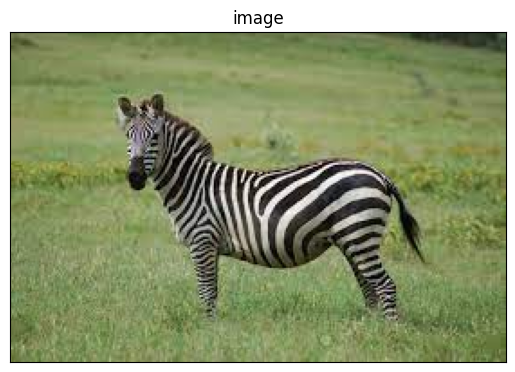

In [46]:
img = cv.imread("zebra.jfif")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt_img(img_rgb, "image")

In [51]:
ret, label, center = kmc(img_rgb, 3)

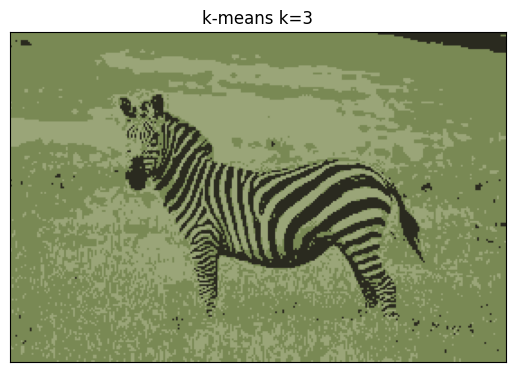

In [52]:
center = np.uint8(center)
res = center[label.flatten()]
quant = res.reshape(img_rgb.shape)

plt_img(quant, "k-means k=3")

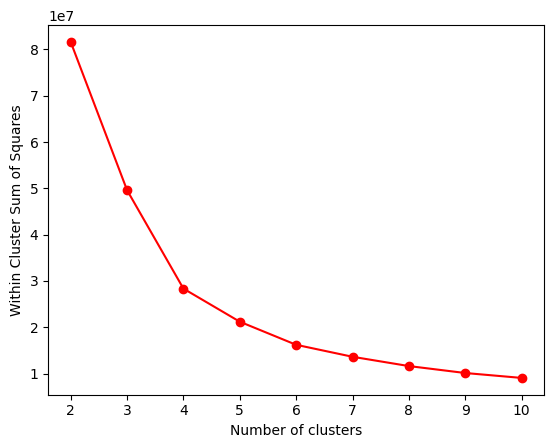

In [78]:
wcss = []
numOfClust = range(2, 11)
for i in numOfClust:
    ret, _, _ = kmc(img_rgb, i) #only interested in the result
    wcss.append(ret)
    
plt.plot(numOfClust, wcss, marker="o", color="r")
plt.ylabel("Within Cluster Sum of Squares")
plt.xlabel("Number of clusters")
plt.show()

#elbow point is k = 4

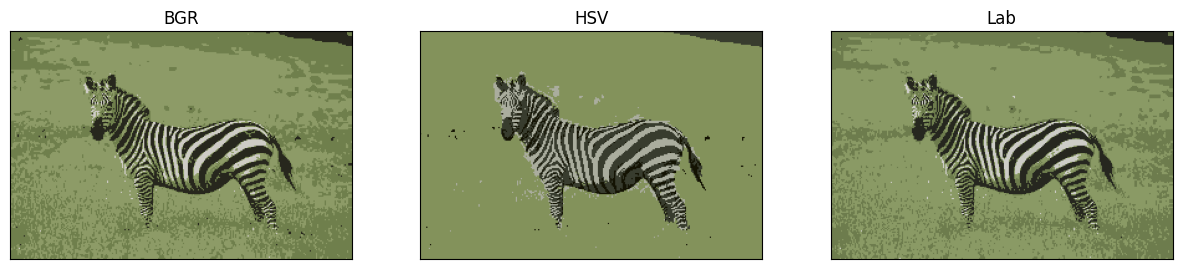

In [86]:
#BGR
ret, label, center = kmc(img, 4)
center = np.uint8(center)
res = center[label.flatten()]
quant = res.reshape(img.shape)
quant_bgr = cv.cvtColor(quant, cv.COLOR_BGR2RGB)

#HSV
img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
ret, label, center = kmc(img_hsv, 4)
center = np.uint8(center)
res = center[label.flatten()]
quant = res.reshape(img_hsv.shape)
quant_hsv = cv.cvtColor(quant, cv.COLOR_HSV2RGB)

#Lab
img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)
ret, label, center = kmc(img_lab, 4)
center = np.uint8(center)
res = center[label.flatten()]
quant = res.reshape(img_lab.shape)
quant_lab = cv.cvtColor(quant, cv.COLOR_Lab2RGB)

plt.figure(figsize=(15,13))
plt.subplot(131), plt_img(quant_bgr, "BGR")
plt.subplot(132), plt_img(quant_hsv, "HSV")
plt.subplot(133), plt_img(quant_lab, "Lab")
plt.show()